In [190]:
import numpy as np
import os
import pandas as pd
from pmi_accuracy import parser

In [6]:
RESULTS_DIR = "results-clean/xlnet-base-cased_pad30_2020-08-07-09-12/"
xlnet_pmi_matrices = np.load(os.path.join(RESULTS_DIR, 'pmi_matrices.npz'))
lstm_logp_matrices = np.load('lstm_logp_matrices.npz')
onlstm_logp_matrices = np.load('onlstm_logp_matrices.npz')

assert len(xlnet_pmi_matrices) == len(
    lstm_logp_matrices) == len(onlstm_logp_matrices)

We are calculating pmi matrix, where this is

$$\mathrm{PMI}({\bf w}_I;{\bf w}_J\mid {\bf w}_{0:J-1,J+1:I-1}) = 
\log \frac{p({\bf w}_I\mid  {\bf w}_{0:I-1})}
          {p({\bf w}_I\mid {\bf w}_{0:J-1,J+1:I-1})} = \log(unmasked) - \log(masked)$$
where ${\bf w}_{0:J-1,J+1:I-1}$ is the sentence up to ${\bf w}_I$, without ${\bf w}_J$.

--

The logp matrices are interpreted as follows: the value in row $r$, column $c$ is the estimated logp of word c+1 when word $r$ is masked.

that is

- in row $r$ we have masked the token in position $r$.
- in column $c$ are logprobabilities for the word in position $c+1$ (so there is one fewer columns than rows).
- if sentence length (without punctuation) $=n$ tokens, then the logp matrix is of size $(n+2)$-by-$(n+1)$, because an `<eos>` token is appended to the beginning and end of the sentence.


So, the final row in the logp matrix is the row of logps with _no masking_ (bc it is masking last element, which isn't seen by model).  So this is our pmi numerator. The entry at position $r,c$ is the logp of word at position $c+1$ when word at position $r$ is masked, so that gives the numerator for PMI. Note we don't care about predictions of `<eos>`, or masking of `<eos>`, so we will ignore the first row, as well as the last, and also the last column.

**For consistency with the other PMI matrices, where rows correspond to target word, columns to masked word, we will transpose this result (so bottom triangle is nonzero).**

In [79]:
def pmi_matrix_from_logp_matrix(input_logp_matrix, transpose=True):
    """Convert nparray of logps to pmi matrix"""
    logp_matrix = input_logp_matrix[:, :-1]  # drop last column
    logp_unmasked = logp_matrix[-1]  # last row is unmasked logps
    # dropping first and last row, subtract from unmasked logps
    pmimat = logp_unmasked - logp_matrix[1:-1]
    if transpose:
        pmimat = pmimat.T
    return(pmimat)


print('for example')
with np.printoptions(precision=2, suppress=True):
    testsen = lstm_logp_matrices.files[1276]
    testmat = lstm_logp_matrices[testsen]
    print(
        testsen,
        pmi_matrix_from_logp_matrix(testmat),
        sep='\n')

for example
1276 <eos> source telerate systems inc <eos>
[[ 0.    0.    0.    0.  ]
 [-0.06  0.    0.    0.  ]
 [ 0.35  3.09  0.    0.  ]
 [ 0.68  2.35  2.42  0.  ]]


In [107]:
counter = 0
for i_sen in lstm_logp_matrices:
    if len(i_sen.split(' ')) < 6 or len(i_sen.split(' ')) > 7:
        continue
    counter += 1
    logp_matrix = lstm_logp_matrices[i_sen]
    print(logp_matrix.shape)
    pmi_matrix = pmi_matrix_from_logp_matrix(logp_matrix)
    with np.printoptions(precision=2, suppress=True):
        print(pmi_matrix, i_sen)
    if counter == 4:
        break

(6, 5)
[[0.   0.   0.   0.  ]
 [1.82 0.   0.   0.  ]
 [1.16 3.27 0.   0.  ]
 [2.44 3.46 4.05 0.  ]] 69 <eos> terms were n't disclosed <eos>
(6, 5)
[[ 0.    0.    0.    0.  ]
 [ 3.74  0.    0.    0.  ]
 [-0.59 -0.47  0.    0.  ]
 [ 0.13 -0.05  0.2   0.  ]] 102 <eos> i love 'em both <eos>
(5, 4)
[[ 0.    0.    0.  ]
 [ 0.54  0.    0.  ]
 [-1.49 -0.11  0.  ]] 123 <eos> that 's baseball <eos>
(6, 5)
[[0.   0.   0.   0.  ]
 [1.91 0.   0.   0.  ]
 [2.4  2.   0.   0.  ]
 [0.52 0.53 1.25 0.  ]] 179 <eos> it 's very frustrating <eos>



# Alignment...
We've got to align these results with the 

In [191]:
mstparser = parser.DepParse('mst', testmat, testsen.split(' '))

In [175]:
s1 = pd.Series(lstm_logp_matrices.files, name='simplified')
s2 = pd.Series(xlnet_pmi_matrices.files, name='not simplified')
sent_comparison = pd.concat([s1, s2], axis=1)
pd.set_option('display.max_colwidth', None)
sent_comparison.head()

,simplified,not simplified
0,0 <eos> influential members of the house ways and means committee introduced legislation that would restrict how the new savings-and-loan bailout agency can raise capital creating another potential obstacle to the government 's sale of sick thrifts <eos>,"0 Influential members of the House Ways and Means Committee introduced legislation that would restrict how the new savings-and-loan bailout agency can raise capital , creating another potential obstacle to the government 's sale of sick thrifts ."
1,1 <eos> the bill whose backers include chairman dan rostenkowski d. ill. would prevent the resolution trust corp. from raising temporary working capital by having an rtc-owned bank or thrift issue debt that would n't be counted on the federal budget <eos>,"1 The bill , whose backers include Chairman Dan Rostenkowski -LRB- D. , Ill. -RRB- , would prevent the Resolution Trust Corp. from raising temporary working capital by having an RTC-owned bank or thrift issue debt that would n't be counted on the federal budget ."
2,2 <eos> the bill intends to restrict the rtc to treasury borrowings only unless the agency receives specific congressional authorization <eos>,"2 The bill intends to restrict the RTC to Treasury borrowings only , unless the agency receives specific congressional authorization ."
3,3 <eos> such agency self-help borrowing is unauthorized and expensive far more expensive than direct treasury borrowing said rep. fortney stark d. calif. the bill 's chief sponsor <eos>,"3 `` Such agency ` self-help ' borrowing is unauthorized and expensive , far more expensive than direct Treasury borrowing , '' said Rep. Fortney Stark -LRB- D. , Calif. -RRB- , the bill 's chief sponsor ."
4,4 <eos> the complex financing plan in the s&l bailout law includes raising N billion from debt issued by the newly created rtc <eos>,4 The complex financing plan in the S&L bailout law includes raising $ 30 billion from debt issued by the newly created RTC .


In [177]:
sent_comparison.loc[396:400]

,simplified,not simplified
396,396 <eos> bsn corp. said it will begin an offer tomorrow to exchange up to one million of its common shares and all of its N.N million in N N\/N % convertible debentures due N for a package of new debt and common stock warrants <eos>,396 BSN Corp. said it will begin an offer tomorrow to exchange up to one million of its common shares and all of its $ 16.6 million in 7 3/4 % convertible debentures due 2001 for a package of new debt and common stock warrants .
397,397 <eos> under terms of the offer the sporting goods maker will swap N face amount of N N\/N % subordinated notes due N and one warrant for each common share <eos>,"397 Under terms of the offer , the sporting goods maker will swap $ 9 face amount of 9 1/4 % subordinated notes due 1996 and one warrant for each common share ."
398,398 <eos> each warrant allows the holder to buy one bsn share for N.N a share at any time over the next seven years <eos>,398 Each warrant allows the holder to buy one BSN share for $ 10.75 a share at any time over the next seven years .
399,399 <eos> bsn currently has N.N million common shares outstanding <eos>,399 BSN currently has 4.6 million common shares outstanding .
400,"400 <eos> bsn also is offering N face amount of new notes and N common-stock warrants for each N,N face amount of its convertible debt outstanding <eos>","400 BSN also is offering $ 850 face amount of new notes and 64 common-stock warrants for each $ 1,000 face amount of its convertible debt outstanding ."


In [176]:
sent_comparison.loc[127:130]

,simplified,not simplified
127,127 <eos> average shares outstanding dropped to N.N million from N.N million <eos>,127 Average shares outstanding dropped to 75.8 million from 82.1 million .
128,128 <eos> revenue fell N % to N.N billion from N.N billion <eos>,128 Revenue fell 1 % to $ 1.39 billion from $ 1.41 billion .
129,129 <eos> the computer maker which sells more than half its goods outside the u.s. also said the negative effect of a stronger u.s. dollar will adversely affect its fourth-quarter performance and make it difficult to better N results <eos>,"129 The computer maker , which sells more than half its goods outside the U.S. , also said the negative effect of a stronger U.S. dollar will `` adversely affect '' its fourth-quarter performance and `` make it difficult '' to better 1988 results ."
130,130 <eos> ncr said revenue declined both in the u.s. and overseas reflecting a world-wide softening of the computer markets <eos>,"130 NCR said revenue declined both in the U.S. and overseas , reflecting a world-wide softening of the computer markets ."


In [178]:
sent_comparison.loc[150:151]

,simplified,not simplified
150,150 <eos> i had calls all night long from the states he said <eos>,"150 `` I had calls all night long from the States , '' he said ."
151,151 <eos> i was woken up every hour N:N N:N N:N N:N <eos>,"151 `` I was woken up every hour -- 1:30 , 2:30 , 3:30 , 4:30 ."


## Plot

In [181]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable


def show_pmi_plot(sent, mat, fig=None, ax=None, title=None):
    lim = max(abs(np.min(mat)), abs(np.max(mat)))
    if ax is None:
        fig, ax = plt.subplots()
    cax = ax.matshow(
        mat, cmap='PuOr',
        norm=colors.TwoSlopeNorm(vcenter=0, vmin=-lim, vmax=lim))
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cax, cax=cax1)
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(sent))))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(sent))))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(sent))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(sent))
    ax.tick_params(axis="x", labelrotation=40)
    ax.set_xlabel('w2 (masked/unmasked conditioner)')
    ax.set_ylabel('w1 (target)')
    ax.yaxis.set_label_position("left")
    if title is not None:
        ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=35,
             ha="left", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=35,
             ha="right", rotation_mode="anchor")
    
def plot_from_logp_matrix(i_sen,logp_matrix):
    pmi_matrix = pmi_matrix_from_logp_matrix(logp_matrix)
    sentence = i_sen.split(' ')[2:-1]
    show_pmi_plot(sent=sentence, mat=pmi_matrix)
    
i_sen_tuples = list(lstm_logp_matrices.items())

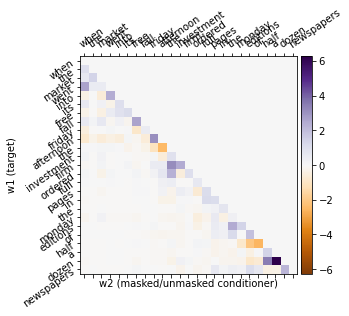

In [183]:
plot_from_logp_matrix(*i_sen_tuples[33])

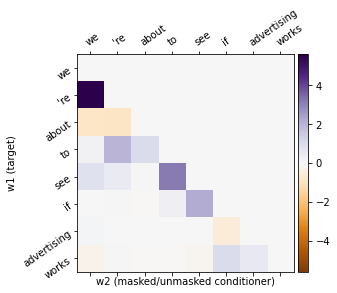

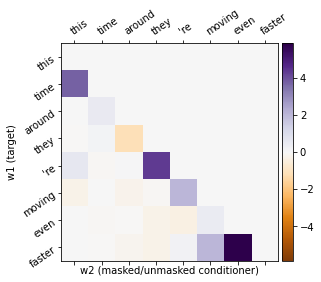

In [182]:
counter = 0
for i_sen in lstm_logp_matrices:
    sen_len = len(i_sen.split(' ')) - 2
    if sen_len < 9 or sen_len > 10:
        continue
    counter += 1
    plot_from_logp_matrix(i_sen,lstm_logp_matrices[i_sen])
    if counter == 2:
        break